In [22]:
import random 
import requests
import pandas as pd
from itertools import product

# URL til SSB API for tabell 03024
api_url = "https://data.ssb.no/api/v0/no/table/03024/"

# Definerer API-spørringen
query = {
    "query": [],
    "response": {
        "format": "json-stat2"
    }
}

# Hente data fra API
response = requests.post(api_url, json=query)

# Sjekke om forespørselen var vellykket
if response.status_code == 200:
    data = response.json()
    
    # Ekstrahere dimensjonsnavn og verdier
    dimension_names = list(data["dimension"].keys())
    values = data["value"]
    
    # Opprette en liste av kombinasjoner av dimensjoner
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    
    # Generere alle kombinasjoner av dimensjonsverdier
    all_combinations = list(product(*dimensions))
    
    # Lage en DataFrame med riktige dimensjoner
    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values  # Knytte verdiene til riktige rader
    
    # Pivotere data for å få ønsket struktur
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    
    # Gi kolonnene mer forståelige navn med riktig rekkefølge
    df_pivot.columns = ["Tid", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    



#Konverter "Tid" til str og fjern "U"
    df_pivot["År"] = df_pivot["Tid"].str[:4].astype(int) # Første 4 tegn er årstall
    df_pivot["Uke"] = df_pivot["Tid"].str[5:].astype(int)  # Etter "U" er uke

#Fjern den opprinnelige "Tid"-kolonnen
    df_pivot = df_pivot.drop(columns=["Tid"])

#Flytt "ÅrUke" først i datasettet
    df_pivot = df_pivot[["Uke"] + [col for col in df_pivot.columns if col not in ["Uke"]]]
    df_pivot = df_pivot[["År"] + [col for col in df_pivot.columns if col not in ["År"]]]


#Skriver ut data 
    print(df_pivot.to_string(index=True))

    print("Data hentet, sortert og formatert for visning.")
else:
    print(f"Feil ved henting av data: {response.status_code}")
    print(response.text)  #Skriver ut feilmeldingen fra API-et





ConnectionError: HTTPSConnectionPool(host='data.ssb.no', port=443): Max retries exceeded with url: /api/v0/no/table/03024/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x145037b10>: Failed to resolve 'data.ssb.no' ([Errno 8] nodename nor servname provided, or not known)"))

In [ ]:
"""
En samlet oversikt over statistisk analyse av laksedataene fra SSB, som viser gjennomsnitt, median og standardavvik for hver variabel over alle år.
"""

import numpy as np
import pandas as pd

#De ulike kolonnene i datasettet som vi bruker
numeriske_kolonner = [
    "Fersk laks - Kilospris", 
    "Fersk laks - Vekt (tonn)", 
    "Frosset laks - Kilospris", 
    "Frosset laks - Vekt (tonn)"
]

#Regner ut statistikken for alle årene til sammen
samlet_statistikk = []

for kol in numeriske_kolonner:
    verdier = df_pivot[kol].dropna()
    samlet_statistikk.append({
        "Variabel": kol,
        "Gjennomsnitt": round(np.mean(verdier), 2),
        "Median": round(np.median(verdier), 2),
        "Standardavvik": round(np.std(verdier), 2)
    })


df_samlet_statistikk = pd.DataFrame(samlet_statistikk)
df_samlet_statistikk.set_index("Variabel", inplace=True)

#visualieres med en tabell som kan scrolle, bruker derfor HTML
from IPython.display import display, HTML

display(HTML(f"""
<div style="width:60%; padding:8px; border:1px solid #ddd; overflow:auto;">
{df_samlet_statistikk.to_html()}
</div>
"""))


,Gjennomsnitt,Median,Standardavvik
Variabel,,,
Fersk laks - Kilospris,45.55,37.94,23.12
Fersk laks - Vekt (tonn),13065.61,13615.50,5762.24
Frosset laks - Kilospris,45.98,40.68,20.77
Frosset laks - Vekt (tonn),625.02,564.00,309.08


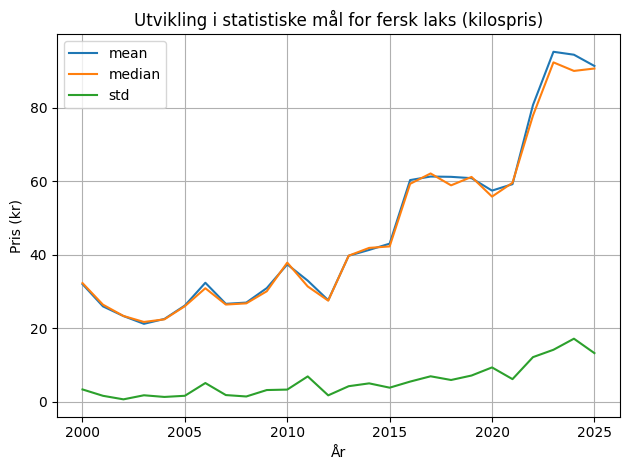

In [ ]:
import matplotlib.pyplot as plt

df_plot = df_pivot.groupby("År")["Fersk laks - Kilospris"].agg(["mean", "median", "std"])
df_plot.plot(title="Utvikling i statistiske mål for fersk laks (kilospris)")
plt.ylabel("Pris (kr)")
plt.xlabel("År")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
from IPython.display import display, HTML
import numpy as np

# Sørg for at du har en 'År'-kolonne i df_pivot
if "År" not in df_pivot.columns:
    df_pivot["År"] = df_pivot["Tid"].str[:4].astype(int)

# Velg numeriske kolonner
numeriske_kolonner = [
    "Fersk laks - Kilospris", 
    "Fersk laks - Vekt (tonn)", 
    "Frosset laks - Kilospris", 
    "Frosset laks - Vekt (tonn)"
]

# Liste for å lagre resultater
statistikk_per_år = []

# Gå gjennom hvert år
for år in sorted(df_pivot["År"].unique()):
    df_år = df_pivot[df_pivot["År"] == år]
    for kol in numeriske_kolonner:
        verdier = df_år[kol].dropna()
        statistikk_per_år.append({
            "År": år,
            "Variabel": kol,
            "Gjennomsnitt": round(np.mean(verdier), 2),
            "Median": round(np.median(verdier), 2),
            "Standardavvik": round(np.std(verdier), 2)
        })



# Bruk pivot_table for å gjøre det oversiktlig
pivot = df_stat_år.pivot_table(
    index="År", 
    columns="Variabel", 
    values=["Gjennomsnitt", "Median", "Standardavvik"]
)

# Sorter kolonne-nivåene for penere utskrift
pivot = pivot.sort_index(axis=1, level=0)



for mål in ["Gjennomsnitt", "Median", "Standardavvik"]:
    print(f"\n🔹 {mål}")
    visning = df_stat_år.pivot(index="År", columns="Variabel", values=mål).round(2)
    display(HTML(visning.to_html()))




🔹 Gjennomsnitt


Variabel,Fersk laks - Kilospris,Fersk laks - Vekt (tonn),Frosset laks - Kilospris,Frosset laks - Vekt (tonn)
År,,,,
2000,32.04,5085.94,37.44,640.75
2001,25.99,4989.46,26.96,693.83
2002,23.36,5204.48,23.02,725.63
2003,21.24,6033.48,23.65,865.94
2004,22.57,6426.75,24.48,913.55
2005,26.22,7441.08,27.17,786.69
2006,32.41,7721.75,35.80,827.65
2007,26.68,9595.21,27.26,923.63
2008,27.02,9900.13,28.62,740.15



🔹 Median


Variabel,Fersk laks - Kilospris,Fersk laks - Vekt (tonn),Frosset laks - Kilospris,Frosset laks - Vekt (tonn)
År,,,,
2000,32.33,4963.0,37.14,621.0
2001,26.45,4924.0,28.34,661.0
2002,23.38,5126.0,23.80,704.5
2003,21.75,5986.5,23.94,842.0
2004,22.46,6436.0,24.44,950.0
2005,26.04,7130.5,26.65,756.5
2006,30.92,7246.5,34.58,768.0
2007,26.48,9440.5,27.42,910.0
2008,26.81,9701.0,28.24,741.5



🔹 Standardavvik


Variabel,Fersk laks - Kilospris,Fersk laks - Vekt (tonn),Frosset laks - Kilospris,Frosset laks - Vekt (tonn)
År,,,,
2000,3.37,1054.06,3.50,217.63
2001,1.65,980.75,3.86,245.25
2002,0.70,1329.39,2.67,240.21
2003,1.79,1356.60,1.46,273.43
2004,1.35,1577.49,1.47,258.80
2005,1.66,1523.56,2.56,308.43
2006,5.09,1817.05,5.29,341.15
2007,1.85,1912.74,2.02,295.52
2008,1.47,1787.55,2.19,291.58


In [ ]:
import seaborn as sns

plt.figure()
sns.catplot(data = df_pivot, kind = "box", x="mean")
plt.title("Oversikt over reading score")